In [58]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [59]:
# example of loading a pix2pix model and using it for one-off image translation
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot
import cv2
from sklearn.metrics import confusion_matrix
from skimage.io import imsave

In [60]:
# load an image
def load_image(filename, size=(256,256)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)
    return pixels

In [61]:
# path images
path_a = '/data/flavio/anatiel/datasets/bk_bases/covid19-256x256/A/train/img3_slc90.jpg'
path_b = '/data/flavio/anatiel/datasets/bk_bases/covid19-256x256/B/train/img3_slc90.jpg'

In [62]:
# load images
src_image = load_image(path_a)
mask_image = load_image(path_b)
print('Loaded image shape', src_image[0].shape)
print('Loaded mask shape', mask_image[0].shape)

Loaded image shape (256, 256, 3)
Loaded mask shape (256, 256, 3)


In [63]:
# load model
model = load_model('/data/flavio/anatiel/models/train_20-01_791epc/model_001474.h5')
opt = Adam(lr=0.0002, beta_1=0.5)
model.compile(loss='binary_crossentropy', optimizer=opt)

In [64]:
# generate image from source
gen_image = model.predict_on_batch(src_image)

In [65]:
# Min max pixel gen image
c = gen_image[0]
print(c.max())
print(c.min())

1.0
-0.025781428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


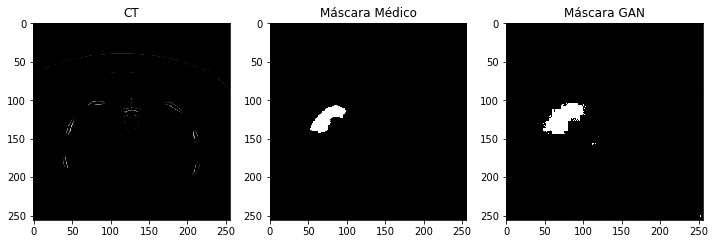

In [66]:
fig, ax = pyplot.subplots(ncols=3, figsize=(12, 5))
ax[0] = pyplot.subplot(1, 3, 1)
ax[1] = pyplot.subplot(1, 3, 2)
ax[2] = pyplot.subplot(1, 3, 3)

ax[0].imshow(src_image[0])
ax[0].set_title('CT')

ax[1].imshow(mask_image[0], cmap="gray")
ax[1].set_title('Máscara Médico')

ax[2].imshow(c, cmap=pyplot.cm.gray)
ax[2].set_title('Máscara GAN')

pyplot.show()

## Redução de Ruídos

In [67]:
kernel = np.ones((4,4),np.uint8)
# MedianBlur
img_median_blur = cv2.medianBlur(c,5)

# Erosion
img_erosion = cv2.erode(img_median_blur, kernel, iterations=1) 

# Dilation
img_dilation = cv2.dilate(img_median_blur, kernel, iterations=1) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


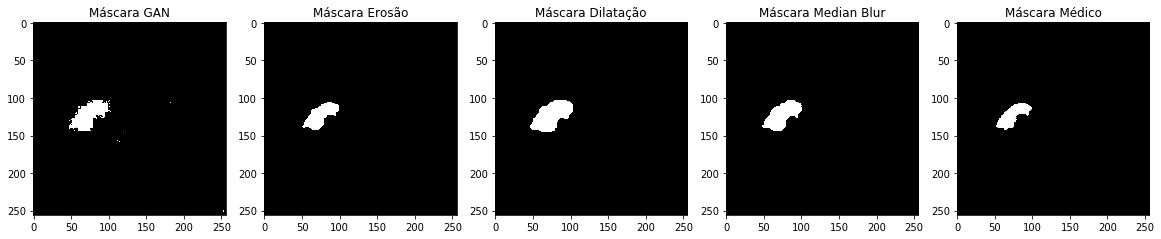

In [68]:
fig, ax = pyplot.subplots(ncols=5, figsize=(20, 5))
ax[0] = pyplot.subplot(1, 5, 1)
ax[1] = pyplot.subplot(1, 5, 2)
ax[2] = pyplot.subplot(1, 5, 3)
ax[3] = pyplot.subplot(1, 5, 4)
ax[4] = pyplot.subplot(1, 5, 5)

ax[0].imshow(c, cmap="gray")
ax[0].set_title('Máscara GAN')

ax[1].imshow(img_erosion, cmap="gray")
ax[1].set_title('Máscara Erosão')

ax[2].imshow(img_dilation, cmap=pyplot.cm.gray)
ax[2].set_title('Máscara Dilatação')

ax[3].imshow(img_median_blur, cmap=pyplot.cm.gray)
ax[3].set_title('Máscara Median Blur')

ax[4].imshow(mask_image[0], cmap=pyplot.cm.gray)
ax[4].set_title('Máscara Médico')

pyplot.show()

## Métricas

In [96]:
# dice
def calculate_dice(image, mask, empty_score=1.0):
    """
        Function for calculate DICE

        Parameters
        ____
            image: get a image segmetation
            mask: get a mask of doctor
            empty_socre: o default = 1.0

        Returns
        ___

            Return the DICE
    """
    
    image = np.asarray(image).astype(np.bool)
    mask = np.asarray(mask).astype(np.bool)
    if image.shape != mask.shape:
        raise ValueError("Shape mismatch: image and mask must have the same shape")

    im_sum = image.sum() + mask.sum()
    if im_sum == 0:
        return empty_score
 
    intersection = np.logical_and(image, mask)

    return 2. * intersection.sum() / im_sum

In [98]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# IoU
from sklearn.metrics import jaccard_score as ajs
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
    
    '''y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou_ = intersection/union
    return iou_'''


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)
(256, 256, 3)


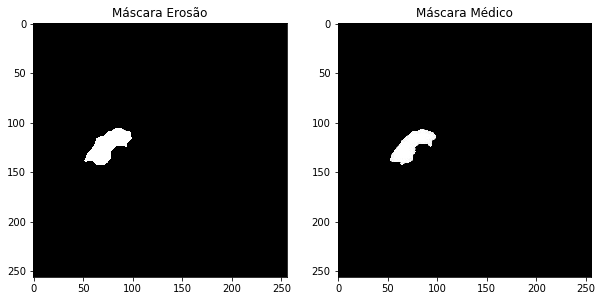

In [105]:
print(np.asarray(mask_image).shape)
print(img_dilation.shape)

fig, ax = pyplot.subplots(ncols=2, figsize=(10, 5))
ax[0] = pyplot.subplot(1, 2, 1)
ax[1] = pyplot.subplot(1, 2, 2)

ax[0].imshow(img_erosion, cmap="gray")
ax[0].set_title('Máscara Erosão')

ax[1].imshow(mask_image[0], cmap=pyplot.cm.gray)
ax[1].set_title('Máscara Médico')

pyplot.show()

In [101]:
jaccard = iou(y_pred_classes, img_erosion)
print("DICE: " , calculate_dice(y_pred_classes, img_erosion))
print("Jaccard: ", jaccard)

DICE:  0.024089846988769127
Jaccard:  0.0121917724609375


## Novo teste de validação do modelo

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# example of loading a pix2pix model and using it for one-off image translation
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot
import cv2
 
# load an image
def load_image(filename, size=(256,256)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = expand_dims(pixels, 0)
    return pixels
 
# load source image
#path_a = '/data/flavio/anatiel/datasets/covid19-256x256/A/val/img8_slc122.jpg'
#path_b = '/data/flavio/anatiel/datasets/covid19-256x256/B/val/img8_slc122.jpg'
src_image = load_image(path_a)
print('Loaded', src_image.shape)
#src_image_blur = cv2.blur(src_image,(5,5))

# load model
#opt = Adam(lr=0.0002, beta_1=0.5)
#model = load_model('/data/flavio/anatiel/models/model_001474.h5')
#model.compile(loss='binary_crossentropy', optimizer=opt)

# generate image from source
gen_image = model.predict_on_batch(src_image)

In [ ]:
# scale from [-1,1] to [0,1]
#gen_image = (gen_image + 1) / 2.0
#gen_image = (gen_image > 128) * 1
print(gen_image.max())

# plot the image
pyplot.imshow(gen_image[0], cmap="gray")
pyplot.show()

## Bibarização

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

limiar = 0.8
maximo = 1

img = img_dilation_median
print(img.max())
print(img.min())

ret,thresh1 = cv2.threshold(img, limiar, maximo, cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img, limiar, maximo, cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img, limiar, maximo, cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img, limiar, maximo, cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img, limiar, maximo, cv2.THRESH_TOZERO_INV)

titles = ['Imagem Original','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()